In [1]:
# import packages
import tensorflow as tf
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

In [2]:
# load data
ratings = pd.read_csv('data/ratings.csv')
to_read = pd.read_csv('data/to_read.csv')
books = pd.read_csv('data/books.csv')

In [3]:
# print out the data
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [5]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [6]:
# the data is too large, therefore we 
# extract the first 200000 users from the data frame
temp = ratings.sort_values(by=['user_id'], ascending=True)
ratings = temp.iloc[:200000, :]

In [7]:
ratings = ratings.reset_index(drop=True)
ratings['List Index'] = ratings.index
readers_group = ratings.groupby("user_id")

In [8]:
# Normalize: divide the ratings by 5
total = []
for readerID, curReader in readers_group:
    temp = np.zeros(len(ratings))
    
    for num, book in curReader.iterrows():
        temp[book['List Index']] = book['rating'] / 5.0
        
    total.append(temp)

random.shuffle(total)
train = total[:1500]
valid = total[1500:]

In [9]:
# hyperparameters
hiddenUnits = 64 # a power of 2 so as to optimally utilize matrix computations on GPU boards
visibleUnits = len(ratings)

# Number of unique books
vb = tf.placeholder(tf.float32, [visibleUnits])

# Number of features that we are going to learn
hb = tf.placeholder(tf.float32, [hiddenUnits])
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix

In [10]:
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb) # Visible layer activation

# Gibb's Sampling
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

In [11]:
# Hidden layer activation
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [12]:
# Reconstruction
#....
# Learning rate
alpha = 0.6

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

In [13]:
# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

Instructions for updating:
Use tf.cast instead.


In [14]:
# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [15]:
# Current weight
cur_w = np.random.normal(loc=0, scale=0.01, size=[visibleUnits, hiddenUnits])

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)

In [16]:
# Running the session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [17]:
def free_energy(v_sample, W, vb, hb):
    ''' Function to compute the free energy '''
    wx_b = np.dot(v_sample, W) + hb
    vbias_term = np.dot(v_sample, vb)
    hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis = 1)
    return -hidden_term - vbias_term

In [18]:
epochs = 60
batchsize = 100
errors = []
energy_train = []
energy_valid = []

for i in range(epochs):
    for start, end in zip(range(0, len(train), batchsize), range(batchsize, len(train), batchsize)):
        batch = train[start:end]
        cur_w = sess.run(update_w, feed_dict={
                         v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={
                          v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={
                          v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb

    energy_train.append(np.mean(free_energy(train, cur_w, cur_vb, cur_hb)))
    energy_valid.append(np.mean(free_energy(valid, cur_w, cur_vb, cur_hb)))

    errors.append(sess.run(err_sum, feed_dict={
                  v0: train, W: cur_w, vb: cur_vb, hb: cur_hb}))
    if i % 10 == 0:
        print("Error in epoch {0} is: {1}".format(i, errors[i]))

Error in epoch 0 is: 0.11402377486228943
Error in epoch 10 is: 0.011539637111127377
Error in epoch 20 is: 0.006279187276959419
Error in epoch 30 is: 0.004431967157870531
Error in epoch 40 is: 0.003493952564895153
Error in epoch 50 is: 0.0029117532540112734


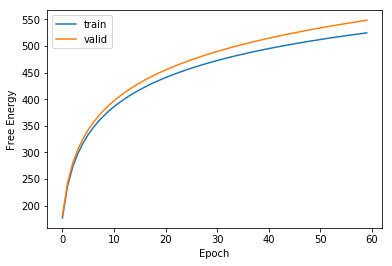

In [19]:
fig, ax = plt.subplots()
ax.plot(energy_train, label='train')
ax.plot(energy_valid, label='valid')
leg = ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Free Energy")
plt.savefig("free_energy.png")
plt.show()

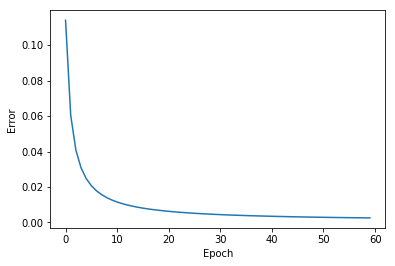

In [20]:
# plot our error curve
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.savefig("error.png")
plt.show()

In [21]:
# pick a random user
user = 100
inputUser = [train[user]]

In [22]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [23]:
# Creating recommendation score for books in our data
ratings["Recommendation Score"] = rec[0]

# Find the mock user's user_id from the data
cur_user_id = ratings.iloc[user]['user_id']

# Find all books the mock user has read before
read_books = ratings[ratings['user_id'] == cur_user_id]['book_id']

# converting the pandas series object into a list
read_books_id = read_books.tolist()

# getting the book names and authors for the books already read by the user
read_books_names = []
read_books_authors = []
for book in read_books_id:
    read_books_names.append(
        books[books['book_id'] == book]['original_title'].tolist()[0])
    read_books_authors.append(
        books[books['book_id'] == book]['authors'].tolist()[0])


In [24]:
# Find all books the mock user has 'not' read before using the to_read data
unread_books = to_read[to_read['user_id'] == cur_user_id]['book_id']
unread_books_id = unread_books.tolist()

# extract the ratings of all the unread books from ratings dataframe
unread_with_score = ratings[ratings['book_id'].isin(unread_books_id)]

# grouping the unread data on book id and taking the mean of the recommendation scores for each book_id
grouped_unread = unread_with_score.groupby('book_id', as_index=False)[
    'Recommendation Score'].mean()

In [25]:
# getting the names and authors of the unread books
unread_books_names = []
unread_books_authors = []
unread_books_scores = []
for book in grouped_unread['book_id']:
    unread_books_names.append(
        books[books['book_id'] == book]['original_title'].tolist()[0])
    unread_books_authors.append(
        books[books['book_id'] == book]['authors'].tolist()[0])
    unread_books_scores.append(
        grouped_unread[grouped_unread['book_id'] == book]['Recommendation Score'].tolist()[0])

In [26]:
# creating a data frame for unread books with their names, authors and recommendation scores
unread_books_with_scores = pd.DataFrame({
    'book_name': unread_books_names,
    'book_authors': unread_books_authors,
    'score': unread_books_scores
})

# creating a data frame for read books with the names and authors
read_books_with_names = pd.DataFrame({
    'book_name': read_books_names,
    'book_authors': read_books_authors
})

# sort the result in descending order of the recommendation score
sorted_result = unread_books_with_scores.sort_values(
    by='score', ascending=False)

# exporting the read and unread books with scores to csv files
read_books_with_names.to_csv('results/read_books_with_names.csv')
sorted_result.to_csv('results/unread_books_with_scores.csv')

print('The books read by the user are:')
print(read_books_with_names)

print('The books recommended to the user are:')
print(sorted_result)

The books read by the user are:
                                             book_name  \
0                                 La sombra del viento   
1                            Luftslottet som sprängdes   
2                               L'élégance du hérisson   
3                                          Three Junes   
4                                   Unaccustomed Earth   
5                                       The Other Hand   
6               Balzac et la Petite Tailleuse chinoise   
7                                       The Book Thief   
8                                  The History of Love   
9                                               Gilead   
10                                        Housekeeping   
11                                             The Sea   
12                                     Never Let Me Go   
13                The Hitchhiker's Guide to the Galaxy   
14                                     The Giving Tree   
15                            The Chroni